In [1]:
import boto3
from sagemaker import image_uris # Use image_uris instead of get_image_uri
from sagemaker import TrainingInput  # Use instead of sagemaker.session.s3_input
from sagemaker.local import LocalSession


In [2]:
sagemaker_session = LocalSession()

In [3]:
region = boto3.Session().region_name

In [4]:
bucket= 'aisemo-pl-dev-34df9971dcc9'
prefix = 'output'
SageMakerRole='arn:aws:iam::898227857609:role/service-role/AmazonSageMaker-ExecutionRole-20210407T124286'

In [5]:
sm_client= boto3.client("sagemaker")
sts_client= boto3.client("sts")

In [6]:
!aws s3 ls

2021-02-18 14:05:10 aisemo-ingest-dev-34df9971dcc9
2021-09-08 12:57:37 aisemo-ingest-dev-eu-central-1-customer-configs-ae3752
2021-02-12 12:43:21 aisemo-ingest-dev-eu-central-1-gateway-artifacts
2021-08-13 09:17:54 aisemo-ingest-dev-eu-central-1-lambda-events-ae3752
2021-06-18 00:05:11 aisemo-ingest-dev-eu-central-1-logs-ae3752
2021-07-28 16:26:09 aisemo-ingest-dev-eu-central-1-tagdata-aggregated-ae3752
2021-08-05 12:56:36 aisemo-ingest-dev-eu-central-1-tagdata-mlsegments-ae3752
2021-02-12 11:40:05 aisemo-ingest-dev-eu-central-1-tagdata-source
2021-07-16 14:48:39 aisemo-ingest-dev-eu-central-1-tagdata-source-ae3752
2021-06-30 14:01:07 aisemo-ingest-dev-eu-central-1-tagdata-transformed-ae3752
2021-02-16 12:50:54 aisemo-ingest-dev-eu-central-1-utils
2020-12-30 21:30:57 aisemo-ingest-dev-terraform-backend-state
2021-06-08 13:59:25 aisemo-logs-dev
2021-06-14 15:09:51 aws-athena-query-results-392543094803-eu-central-1
2021-06-23 09:08:50 aws-cloudtrail-logs-392543094803-0f3ee2a2
2021-04-19 

# TensorFlow Script Mode - Using Shell scripts

Starting from TensorFlow version 1.11, you can use a shell script as
your training entry point. Shell scripts are useful for many use cases including:

- Invoking Python scripts with specific parameters
- Configuring framework dependencies
- Training using different programming languages

For this example, we use [a Keras implementation of the Deep Dream algorithm](https://github.com/keras-team/keras/blob/2.2.4/examples/deep_dream.py). We can use the same technique for other scripts or repositories including [TensorFlow Model Zoo](https://github.com/tensorflow/models) and [TensorFlow benchmark scripts](https://github.com/tensorflow/benchmarks/tree/master/scripts/tf_cnn_benchmarks).

# Getting the image for training
For training data, let's download a public domain image:

In [7]:
import os

data_dir = os.path.join(os.getcwd(), "training")

os.makedirs(data_dir, exist_ok=True)
data_dir

'/Users/danatomic/Dev/Sagemaker/local-sagemaker/amazon-sagemaker-examples/sagemaker-python-sdk/tensorflow_script_mode_using_shell_commands/training'

In [8]:
!wget -O training/dark-forest-landscape.jpg https://www.goodfreephotos.com/albums/other-landscapes/dark-forest-landscape.jpg

--2021-10-05 17:17:31--  https://www.goodfreephotos.com/albums/other-landscapes/dark-forest-landscape.jpg
Resolving www.goodfreephotos.com (www.goodfreephotos.com)... 208.78.226.237
Connecting to www.goodfreephotos.com (www.goodfreephotos.com)|208.78.226.237|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 651831 (637K) [image/jpeg]
Saving to: ‘training/dark-forest-landscape.jpg’

training/dark-fores 100%[===================>] 636,55K   797KB/s    in 0,8s    

2021-10-05 17:17:33 (797 KB/s) - ‘training/dark-forest-landscape.jpg’ saved [651831/651831]



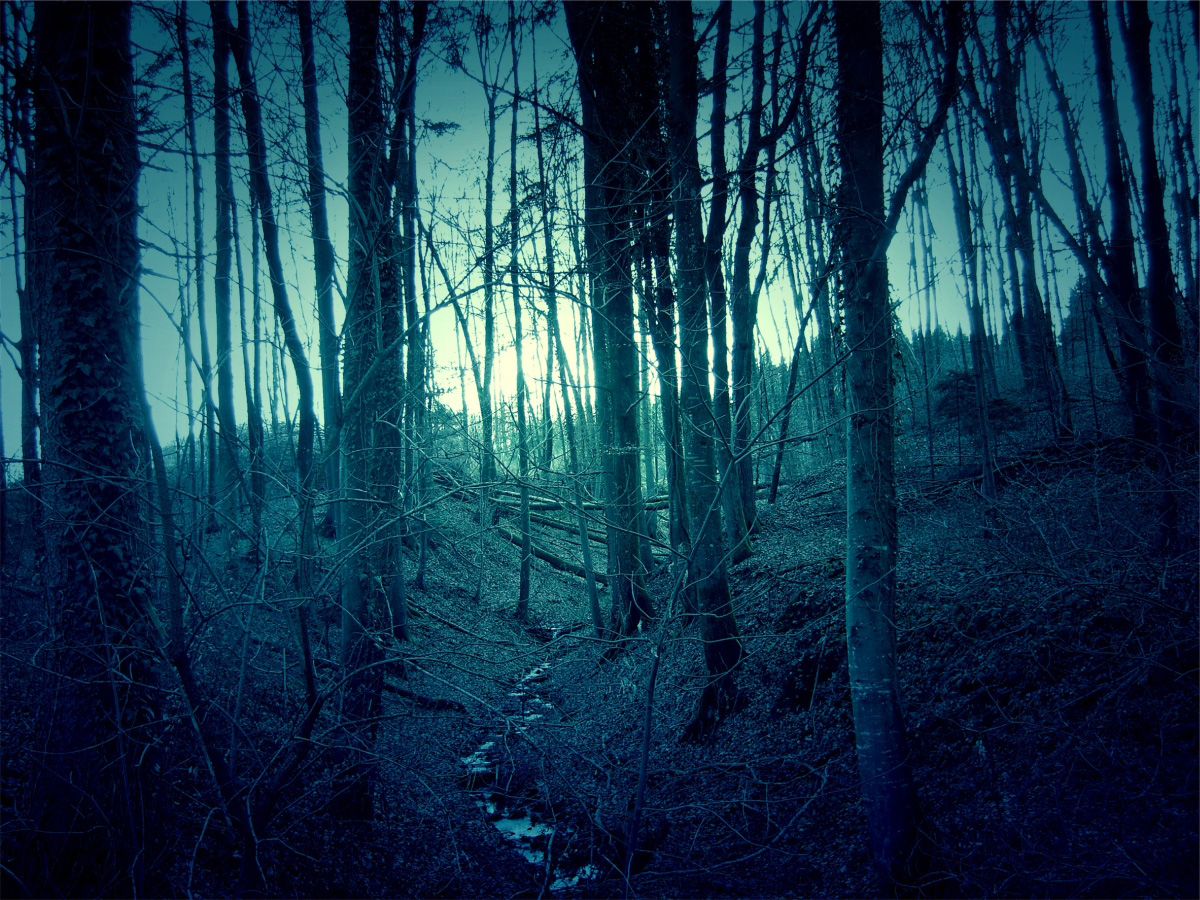

In [9]:
from IPython.display import Image

Image(filename="training/dark-forest-landscape.jpg")

## Download the training script

Let's start by downloading the [deep_dream](https://github.com/keras-team/keras/blob/2.2.4/examples/deep_dream.py) example script from Keras repository. This script takes an image and uses deep dream algorithm to generate
transformations of that image.

In [10]:
!wget https://raw.githubusercontent.com/keras-team/keras/2.2.4/examples/deep_dream.py

--2021-10-05 17:17:35--  https://raw.githubusercontent.com/keras-team/keras/2.2.4/examples/deep_dream.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.110.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6181 (6,0K) [text/plain]
Saving to: ‘deep_dream.py.1’

deep_dream.py.1     100%[===================>]   6,04K  --.-KB/s    in 0s      

2021-10-05 17:17:35 (36,2 MB/s) - ‘deep_dream.py.1’ saved [6181/6181]



The script **deep_dream.py** takes two positional arguments:
- `base_image_path`: Path to the image to transform.
- `result_prefix`: Prefix of all generated images.

### Creating the launcher script

We need to create a launcher script that sets the `base_image_path` 
and `result_prefix`, and invokes **deep_dream.py**:

In [11]:
%%writefile launcher.sh 

BASE_IMAGE_PATH="${SM_CHANNEL_TRAINING}/dark-forest-landscape.jpg"
RESULT_PREFIX="${SM_MODEL_DIR}/dream"

python deep_dream.py ${BASE_IMAGE_PATH} ${RESULT_PREFIX}

echo "Generated image $(ls ${SM_MODEL_DIR})"

Overwriting launcher.sh


**SM_CHANNEL_TRAINING** and **SM_MODEL** are environment variables created by the SageMaker TensorFlow
Container in the beginning of training. Let's take a more detailed look at then: 

- **SM_MODEL_DIR**: the directory inside the container where the training model data must be saved inside the container, i.e. /opt/ml/model.
- **SM_TRAINING_CHANNEL**: the directory containing data in the 'training' channel. 

For more information about training environment variables, please visit [SageMaker Containers](https://github.com/aws/sagemaker-containers#list-of-provided-environment-variables-by-sagemaker-containers).

## Test locally using SageMaker Python SDK TensorFlow Estimator
You can use the SageMaker Python SDK TensorFlow estimator to easily train locally and in SageMaker.
Let's set **launcher.sh** as the entry-point and **deep_dream.py** as a dependency:

In [12]:
entry_point = "launcher.sh"
dependencies = ["deep_dream.py"]

For more information about the arguments `entry_point` and `dependencies` see the [SageMaker TensorFlow](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/README.rst#sagemakertensorflowtensorflow-class) documentation.

This notebook shows how to use the SageMaker Python SDK to run your code in a local container before deploying to SageMaker's managed training or hosting environments. Just change your estimator's train_instance_type to local or local_gpu. For more information, see: https://github.com/aws/sagemaker-python-sdk#local-mode.

In order to use this feature you'll need to install docker-compose (and nvidia-docker if training with a GPU). Running following script will install docker-compose or nvidia-docker-compose and configure the notebook environment for you.

Note, you can only run a single local notebook at a time.

In [19]:
!/bin/sh ./setup.sh

: command not found 
: command not found: 
: ambiguous redirect 1
./setup.sh: line 85: syntax error near unexpected token `fi'
./setup.sh: line 85: `fi'


Let's train locally here to make sure everything runs smoothly first.

In [15]:
train_instance_type = "local"

We create the TensorFlow Estimator, passing the flag `script_mode=True`. For more information about script mode, see https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/README.rst#preparing-a-script-mode-training-script:

In [26]:
import sagemaker
from sagemaker.tensorflow import TensorFlow

estimator = TensorFlow(
    entry_point=entry_point,
    dependencies=dependencies,
    instance_type="local",
    instance_count=1,
    role=SageMakerRole,
    framework_version="1.14",
    py_version="py3",
    script_mode=True,
)

To start a training job, we call `estimator.fit(inputs)`, where inputs is a dictionary where the keys, named **channels**, have values pointing to the data location:

In [27]:
inputs = {"training": f"file://{data_dir}"}

estimator.fit(inputs)

WARNING! Using --password via the CLI is insecure. Use --password-stdin.


Creating network "sagemaker-local" with the default driver
Creating wgk94iy4ld-algo-1-zix3b ... 
Creating wgk94iy4ld-algo-1-zix3b ... done
Attaching to wgk94iy4ld-algo-1-zix3b
wgk94iy4ld-algo-1-zix3b | /usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
wgk94iy4ld-algo-1-zix3b |   _np_qint8 = np.dtype([("qint8", np.int8, 1)])
wgk94iy4ld-algo-1-zix3b | /usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
wgk94iy4ld-algo-1-zix3b |   _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
wgk94iy4ld-algo-1-zix3b | /usr/local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (t

`estimator.model_data` contains the S3 location where the contents of **/opt/ml/model**
were save as tar.gz file. Let's untar and download the model:

In [28]:
!aws s3 cp {estimator.model_data} model.tar.gz
!tar -xvzf model.tar.gz

download: s3://sagemaker-eu-central-1-392543094803/tensorflow-training-2021-10-05-15-03-57-852/model.tar.gz to ./model.tar.gz
x dream.png


We can see the resulting image now:

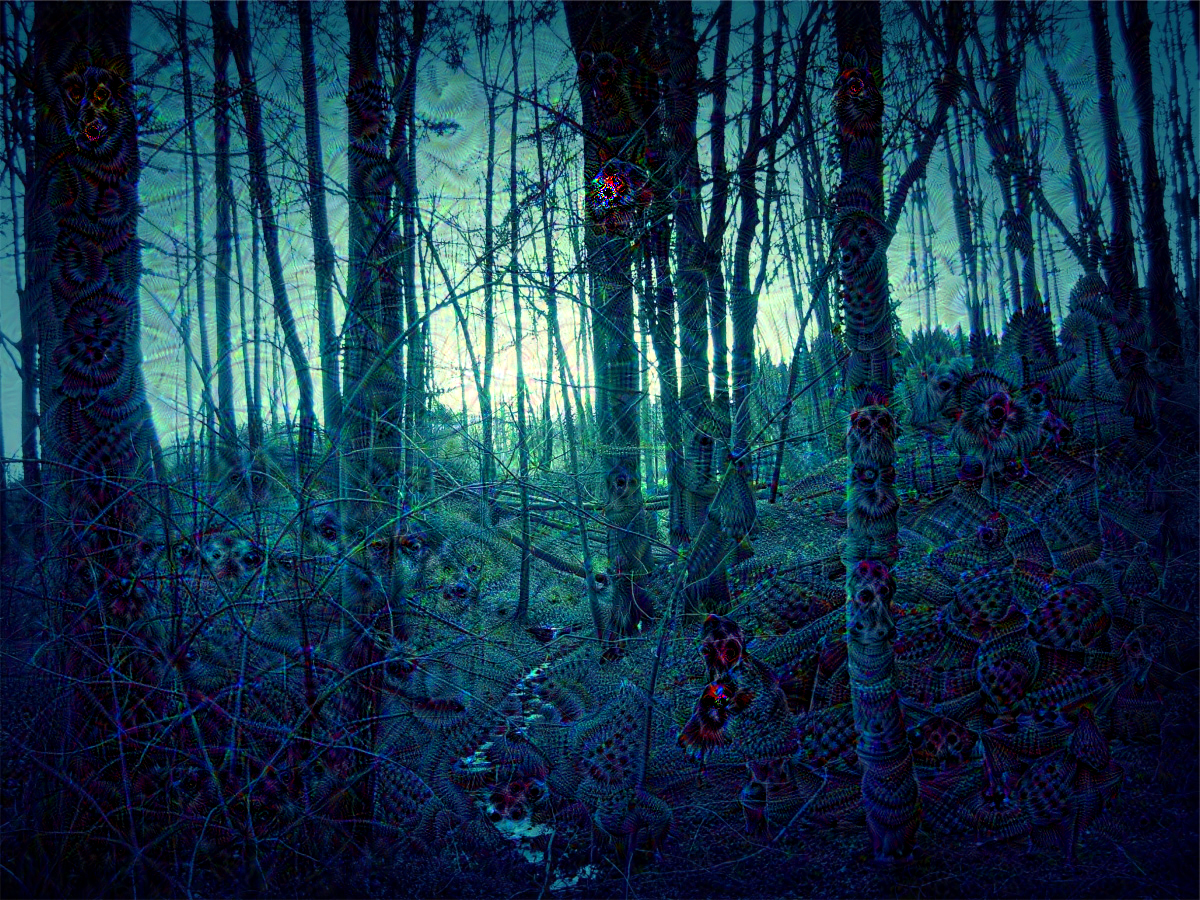

In [29]:
from IPython.display import Image

Image(filename="dream.png")

# Training in SageMaker

After you test the training job locally, upload the dataset to an S3 bucket so SageMaker can access the data during training:

In [ ]:
import sagemaker

training_data = sagemaker.Session().upload_data(path="training", key_prefix="datasets/deep-dream")

The `upload_data` call above returns an S3 location that can be used during the SageMaker Training Job

In [ ]:
training_data

To train in SageMaker: change the estimator argument **train_instance_type** to any SageMaker ML Instance Type available for training.


In [ ]:
estimator = TensorFlow(
    entry_point="launcher.sh",
    dependencies=["deep_dream.py"],
    train_instance_type="ml.c4.xlarge",
    train_instance_count=1,
    role=sagemaker.get_execution_role(),
    framework_version="1.14",
    py_version="py3",
    script_mode=True,
)

The `estimator.fit` call bellow starts training and creates a data channel named `training` with the contents of the
 S3 location `training_data`.

In [ ]:
estimator.fit(training_data)